# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [2]:
# Set default figsize to 10 inches by 6 inches
plt.rcParams["figure.figsize"] = (10,6)

# Functions

In [3]:
def plot_series(time,series,format="-",start=0,end=None,label=None):
  plt.plot(time[start:end],series[start:end])
  plt.xlabel("Time")
  plt.ylabel("Value")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

In [4]:
def trend(time,slope=0):
  return time * slope

In [5]:
def seasonal_pattern(season_time):
  return np.where(season_time < 0.4,
                  np.cos(season_time * 2 * np.pi),
                  1 / np.exp(3 * season_time))

In [6]:
def seasonality(time,period,amplitude=1,phase =0):
  season_time = ((time + phase)) % period / period
  return amplitude * seasonal_pattern(season_time)

In [7]:
def white_noise(time,noise_level =1 , seed = None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level

In [8]:
def seq2seq_window_dataset(series, window_size, batch_size = 32,
                           shuffle_buffer = 1000):
  series = tf.expand_dims(series,axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1,shift=1,drop_remainder = True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1],w[1:]))
  return ds.batch(batch_size).prefetch(1)

In [25]:
def model_forecast(model,series,window_size,batch_size= 32):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size,shift = 1,drop_remainder = True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(batch_size).prefetch(1)
  forecast = model.predict(ds)
  return forecast

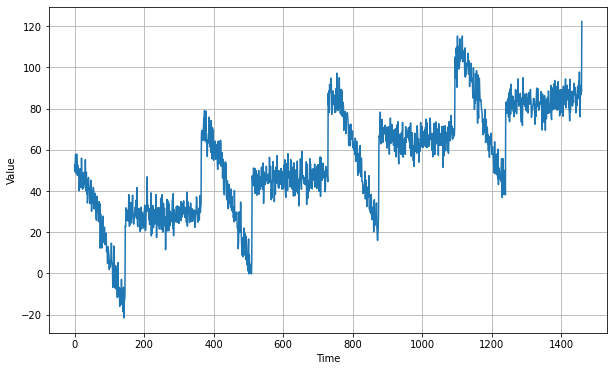

In [12]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
period = 365

series = baseline + trend(time,slope) + seasonality(time,period,amplitude=amplitude)

noise_level = 5
noise = white_noise(time,noise_level,seed=42)

series += noise

plot_series(time,series)
plt.show()

In [13]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]

valid_time = time[split_time:]
x_valid = series[split_time:]

# Preprocessing with A 1d CNN

In [16]:
%%time 

keras.backend.clear_session()

tf.random.set_seed(42)
np.random.seed(42)

window_size = 30

train_set = seq2seq_window_dataset(x_train,window_size,batch_size=128)

model = keras.models.Sequential([
  keras.layers.Conv1D(filters= 32,kernel_size=5,
                      strides=1,padding='causal',
                      activation='relu',
                      input_shape=[None,1]),
  keras.layers.LSTM(32,return_sequences=True),
  keras.layers.LSTM(32,return_sequences=True),
  keras.layers.Dense(2),
  keras.layers.Lambda(lambda x: x * 200.0)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10 **(epoch/20))

optimizer = keras.optimizers.SGD(lr=1e-8,momentum=0.9)

model.compile(loss = keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae'])

history = model.fit(train_set,epochs=100,callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 32s 13ms/step - loss: 82.2285 - mae: 82.7280
Epoch 2/100
8/8 [==============================] - 0s 7ms/step - loss: 82.1835 - mae: 82.6828
Epoch 3/100
8/8 [==============================] - 0s 7ms/step - loss: 80.9572 - mae: 81.4564
Epoch 4/100
8/8 [==============================] - 0s 8ms/step - loss: 79.8602 - mae: 80.3595
Epoch 5/100
8/8 [==============================] - 0s 8ms/step - loss: 77.2776 - mae: 77.7767
Epoch 6/100
8/8 [==============================] - 0s 7ms/step - loss: 72.8627 - mae: 73.3617
Epoch 7/100
8/8 [==============================] - 0s 6ms/step - loss: 65.7772 - mae: 66.2759
Epoch 8/100
8/8 [==============================] - 0s 6ms/step - loss: 64.4240 - mae: 64.9224
Epoch 9/100
8/8 [==============================] - 0s 6ms/step - loss: 64.0502 - mae: 64.5483
Epoch 10/100
8/8 [==============================] - 0s 6ms/step - loss: 62.7764 - mae: 63.2745
Epoch 11/100
8/8 [==============================] - 0s 7m

(1e-08, 0.0001, 0.0, 30.0)

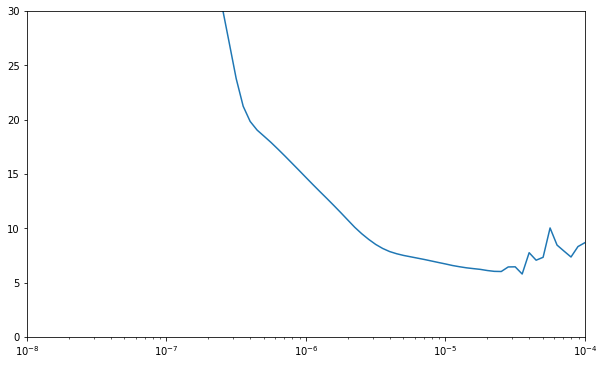

In [18]:
# Plot learning rate curve
plt.semilogx(history.history['lr'],history.history['loss'])
plt.axis([1e-8,1e-4,0,30])

# Now that we got the learning rate curve lets create our actual model

In [30]:
%%time

keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
batch_size = 128

train_set = seq2seq_window_dataset(x_train,window_size,batch_size=batch_size)
valid_set = seq2seq_window_dataset(x_valid,window_size,batch_size=batch_size)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters = 32, kernel_size = 5,
                        strides = 1, padding="causal",
                        activation = 'relu',
                        input_shape=[None,1]),
    keras.layers.LSTM(32,return_sequences=True),
    keras.layers.LSTM(32,return_sequences=True),
    keras.layers.Dense(2),
    keras.layers.Lambda(lambda x: x * 200)
])
optimizer = keras.optimizers.SGD(lr=1e-5,momentum=0.9)
model.compile(loss = keras.losses.Huber(),
              optimizer = optimizer,
              metrics=['mae'])
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5",save_best_only = True
)
early_stopping = keras.callbacks.EarlyStopping(patience=40)

model.fit(train_set,
          epochs=500,
          validation_data = valid_set,
          callbacks=[early_stopping,model_checkpoint])

Epoch 1/500
8/8 [==============================] - 3s 107ms/step - loss: 35.6730 - mae: 36.1704 - val_loss: 21.2280 - val_mae: 21.7240
Epoch 2/500
8/8 [==============================] - 0s 23ms/step - loss: 23.5259 - mae: 24.0219 - val_loss: 37.5267 - val_mae: 38.0254
Epoch 3/500
8/8 [==============================] - 0s 23ms/step - loss: 17.1991 - mae: 17.6929 - val_loss: 36.5793 - val_mae: 37.0786
Epoch 4/500
8/8 [==============================] - 0s 22ms/step - loss: 13.5853 - mae: 14.0774 - val_loss: 27.0451 - val_mae: 27.5429
Epoch 5/500
8/8 [==============================] - 0s 23ms/step - loss: 11.2387 - mae: 11.7274 - val_loss: 22.6681 - val_mae: 23.1644
Epoch 6/500
8/8 [==============================] - 0s 22ms/step - loss: 9.6310 - mae: 10.1182 - val_loss: 20.2592 - val_mae: 20.7562
Epoch 7/500
8/8 [==============================] - 0s 26ms/step - loss: 9.2735 - mae: 9.7589 - val_loss: 18.6224 - val_mae: 19.1183
Epoch 8/500
8/8 [==============================] - 0s 23ms/step 

In [31]:
model = keras.models.load_model("my_checkpoint.h5")

In [32]:
rnn_forecast = model_forecast(model, series[:,  np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

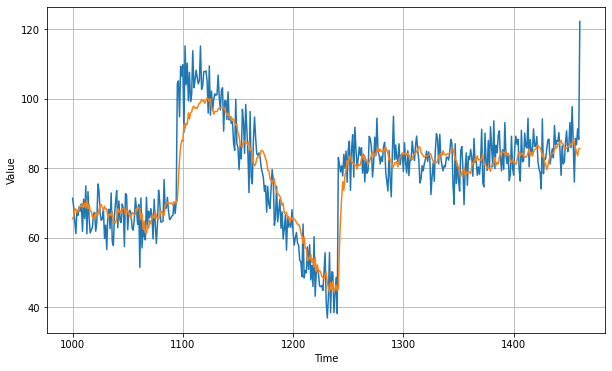

In [33]:
plot_series(valid_time,x_valid)
plot_series(valid_time,rnn_forecast)

In [34]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.252112

# Fully Convolutional Forecasting with dilationg

In [37]:
%%time


keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
batch_size = 128

train_set = seq2seq_window_dataset(x_train,window_size,
                                   batch_size=batch_size)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None,1]))

for dilation_rate in (1,2,4,8,16,32):
  model.add(keras.layers.Conv1D(filters=32,
                                kernel_size=2,
                                strides=1,
                                dilation_rate=dilation_rate,
                                padding = 'causal',
                                activation = 'relu'))
model.add(keras.layers.Conv1D(filters=1,kernel_size=1))
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch:1e-4 * 10 ** (epoch/30)
)
optimizer = keras.optimizers.Adam(lr=1e-4)

model.compile(loss = keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae'])

history = model.fit(train_set,epochs = 100,callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 2s 15ms/step - loss: 42.1080 - mae: 42.6069
Epoch 2/100
8/8 [==============================] - 0s 5ms/step - loss: 41.2128 - mae: 41.7118
Epoch 3/100
8/8 [==============================] - 0s 6ms/step - loss: 41.9048 - mae: 42.4040
Epoch 4/100
8/8 [==============================] - 0s 6ms/step - loss: 41.4797 - mae: 41.9787
Epoch 5/100
8/8 [==============================] - 0s 6ms/step - loss: 40.6822 - mae: 41.1811
Epoch 6/100
8/8 [==============================] - 0s 6ms/step - loss: 39.9483 - mae: 40.4471
Epoch 7/100
8/8 [==============================] - 0s 7ms/step - loss: 38.0289 - mae: 38.5276
Epoch 8/100
8/8 [==============================] - 0s 6ms/step - loss: 37.2201 - mae: 37.7189
Epoch 9/100
8/8 [==============================] - 0s 8ms/step - loss: 34.3746 - mae: 34.8731
Epoch 10/100
8/8 [==============================] - 0s 6ms/step - loss: 29.1636 - mae: 29.6614
Epoch 11/100
8/8 [==============================] - 0s 7ms

(0.0001, 0.1, 0.0, 30.0)

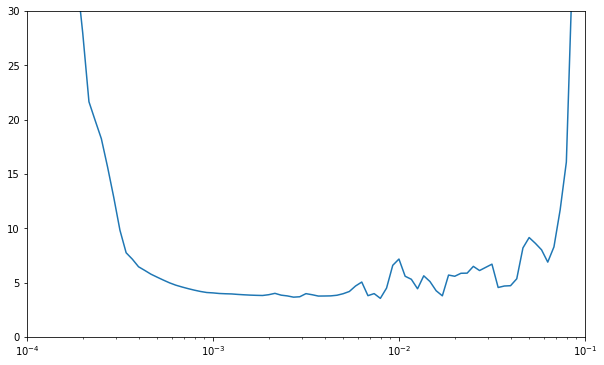

In [39]:
plt.semilogx(history.history['lr'],history.history['loss'])
plt.axis([1e-4,1e-1,0,30])

In [40]:
# Since we now have the best learning rate lets create our actual model
%%time

keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
batch_size = 128

train_set = seq2seq_window_dataset(x_train,window_size,batch_size=batch_size)

valid_set = seq2seq_window_dataset(x_valid,window_size=window_size,batch_size=batch_size)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None,1]))

for dilation_rate in (1,2,3,8,16,32):
  model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding='causal',
                          activation='relu')
  )
model.add(keras.layers.Conv1D(filters=1,kernel_size=1))
optimizer = keras.optimizers.Adam(lr=3e-4)
model.compile(loss= keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae'])
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5",save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
history = model.fit(train_set,
                    epochs=500,
                    validation_data = valid_set,
                    callbacks=[early_stopping,model_checkpoint])

Epoch 1/500
8/8 [==============================] - 2s 76ms/step - loss: 40.2776 - mae: 40.7764 - val_loss: 72.8580 - val_mae: 73.3580
Epoch 2/500
8/8 [==============================] - 0s 22ms/step - loss: 37.8471 - mae: 38.3456 - val_loss: 67.8194 - val_mae: 68.3194
Epoch 3/500
8/8 [==============================] - 0s 23ms/step - loss: 35.9536 - mae: 36.4522 - val_loss: 60.5786 - val_mae: 61.0786
Epoch 4/500
8/8 [==============================] - 0s 23ms/step - loss: 31.7885 - mae: 32.2868 - val_loss: 49.7522 - val_mae: 50.2519
Epoch 5/500
8/8 [==============================] - 0s 24ms/step - loss: 25.7962 - mae: 26.2934 - val_loss: 36.0919 - val_mae: 36.5877
Epoch 6/500
8/8 [==============================] - 0s 23ms/step - loss: 20.3086 - mae: 20.8030 - val_loss: 31.7205 - val_mae: 32.2177
Epoch 7/500
8/8 [==============================] - 0s 23ms/step - loss: 18.6725 - mae: 19.1673 - val_loss: 29.6773 - val_mae: 30.1746
Epoch 8/500
8/8 [==============================] - 0s 22ms/ste

In [42]:
model = keras.models.load_model("my_checkpoint.h5")

In [43]:
cnn_forecast = model_forecast(model,series[...,np.newaxis],window_size)
cnn_forecast = cnn_forecast[split_time - window_size:-1,-1,0]

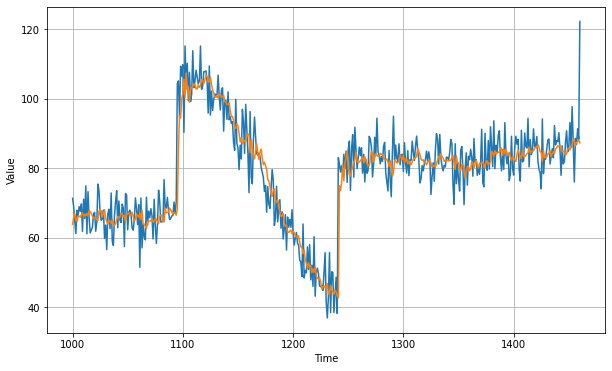

In [45]:
plot_series(valid_time,x_valid)
plot_series(valid_time,cnn_forecast)

In [46]:
keras.metrics.mean_absolute_error(x_valid, cnn_forecast).numpy()

4.5706635